In [5]:
# %%
import os  

import numpy as np
import pandas as pd



from icecream import ic


from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,mean_squared_error,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFECV

import scipy.io
import matplotlib.pyplot as plt

from tensorly.decomposition import parafac
import tensorly as tl


from TKL import TKL
from KL import KL

from utils import *


group = "AD_CN"
# group = "AD_MCI"
# group = "CN_MCI"
# load data
args_dataPathList = fr'./data/{group}/GM.csv,./data/{group}/PET.csv,./data/{group}/CSF.csv,./data/{group}/SNP.csv'
dataPathList = [str(item) for item in args_dataPathList.split(',')]
X_list = []
for dataPath in dataPathList:
  X = pd.read_csv(dataPath,header=None).values
  X_list.append(X)

df_y = pd.read_csv(fr'./data/{group}/{group}_label.csv')    
y = df_y['encoded']
le = LabelEncoder()
y = le.fit_transform(y)

#split data   
exp = 10
Z = range(len(y)) 
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=exp)

In [2]:
for modality in range(4):
  X_train = X_list[modality][Z_train,:]
  X_test = X_list[modality][Z_test,:]

  clf = KL()
  clf.fit(X_train,y_train)

  y_pred = clf.predict(X_test)
  cf  = confusion_matrix(y_pred, y_test)
  acc = round(np.sum(np.diag(cf))/ np.sum(cf)*100,2)
  ic(f"Modality: {modality}",cf, acc)

ic| f"Modality: {modality}": 'Modality: 0'
    cf: array([[19,  5],
               [ 5, 18]])
    acc: 78.72
ic| f"Modality: {modality}": 'Modality: 1'
    cf: array([[20,  5],
               [ 4, 18]])
    acc: 80.85
ic| f"Modality: {modality}": 'Modality: 2'
    cf: array([[18,  3],
               [ 6, 20]])
    acc: 80.85
ic| f"Modality: {modality}": 'Modality: 3'
    cf: array([[12,  8],
               [12, 15]])
    acc: 57.45


In [3]:
X_train = X_list[1][Z_train,:]
X_train.shape, y_train

((184, 200),
 array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 1]))

## Feature selection

In [56]:
# Assuming X_list, Z_train, Z_test, y_train, and y_test are defined elsewhere
from sklearn.feature_selection import RFE

modality = 1  # Assuming modality 1 is PET

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]

# Initialize the model you want to use
#model = RandomForestClassifier()
model = SVC(kernel='linear')


# Initialize RFE with the model and the number of features to select
# Here, we want to select 2 features, or you could use a fraction like 0.5 to select half of the features
selector = RFE(model, n_features_to_select=130)

# Fit RFE
selector = selector.fit(X_train, y_train)

# Transform the data according to the RFE selection
X_train_transformed = selector.transform(X_train)

In [57]:
# Fit the model KL with the selected features
clf = KL()
clf.fit(X_train_transformed, y_train)

# Transform the test data based on the selected features
X_test_transformed = selector.transform(X_test)

# Predict using the selected features of the test data
y_pred = clf.predict(X_test_transformed)
cf = confusion_matrix(y_pred, y_test)
acc = round(np.sum(np.diag(cf)) / np.sum(cf) * 100, 2)
print(f"Modality: {modality}", cf, acc)


Modality: 1 [[20  3]
 [ 4 20]] 85.11


In [40]:
# Write the code to select the features based on the RFE selection recorded list of n_features_to_select
# You can use the selector.support_ attribute to get the indices of the selected features
selected_features = np.where(selector.support_)[0]
selected_features


array([ 16,  40,  45,  52,  53,  57,  66,  67,  74,  76,  78,  83, 100,
       107, 162, 171, 172, 180, 183, 185])

Number of features: 1
Number of features: 21
Number of features: 41
Number of features: 61
Number of features: 81
Number of features: 101
Number of features: 121
Number of features: 141
Number of features: 161
Number of features: 181


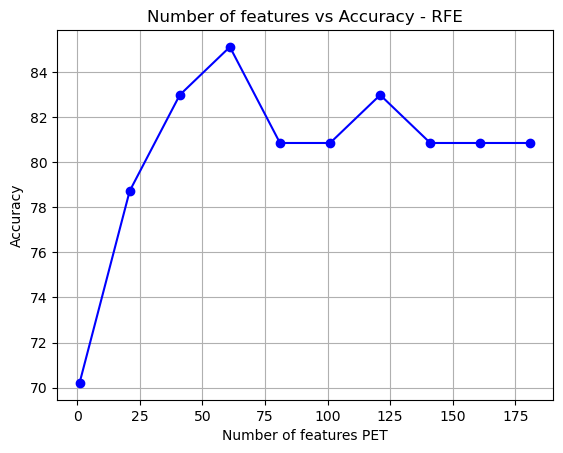

In [30]:
from sklearn.feature_selection import RFE

# n_features_to_select is list of begin 0 to 200 with step 20
n_features_to_select = range(1, 200, 20)
modality = 1  # Assuming modality 1 is PET

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]

# Initialize the model you want to use
model = RandomForestClassifier()

accs = []
for n_features in n_features_to_select:
    print(f"Number of features: {n_features}")


    selector = RFE(model, n_features_to_select=n_features)
    selector = selector.fit(X_train, y_train)
    X_train_transformed = selector.transform(X_train)
    clf = KL()
    clf.fit(X_train_transformed, y_train)
    X_test_transformed = selector.transform(X_test)
    y_pred = clf.predict(X_test_transformed)
    cf = confusion_matrix(y_pred, y_test)
    acc = round(np.sum(np.diag(cf)) / np.sum(cf) * 100, 2)
    accs.append(acc)


plt.plot(n_features_to_select, accs, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of features PET")
plt.ylabel("Accuracy")
plt.title("Number of features vs Accuracy - RFE")
plt.grid(True)
# Save figure
plt.savefig("RFE.png")

plt.show()



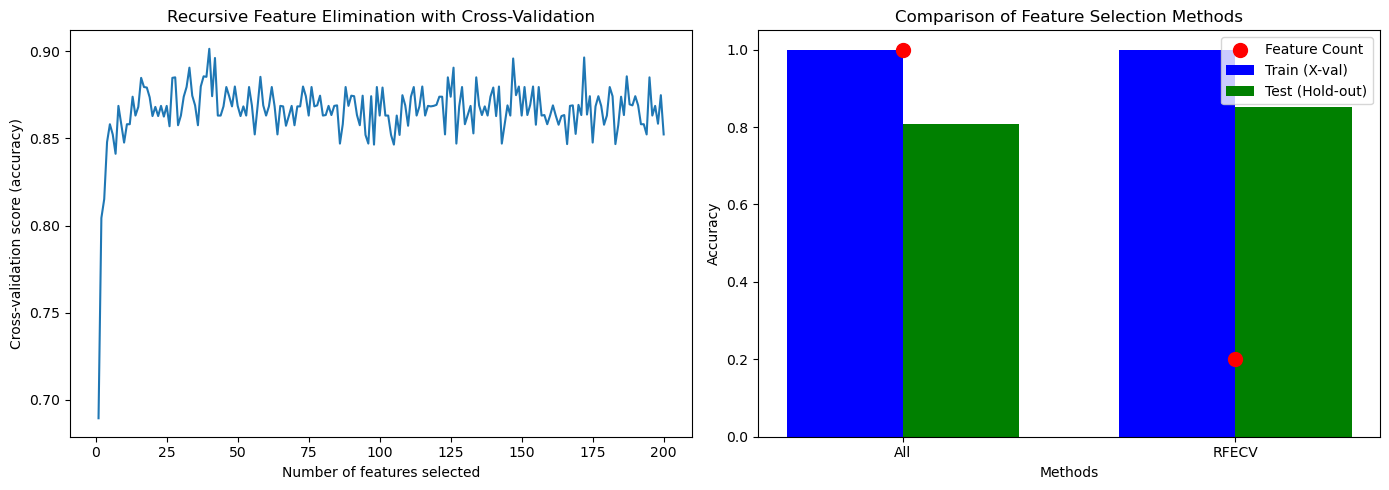

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

modality = 1  # Assuming modality 1 is PET

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]

# Initialize model
model = SVC(kernel='linear')
#model = RandomForestClassifier()

# Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=KFold(10), scoring='accuracy')
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.title("Recursive Feature Elimination with Cross-Validation")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])

# Comparison plot
methods = ['All', 'RFECV']
train_accuracy = [model.fit(X_train, y_train).score(X_train, y_train),
                  rfecv.score(X_train, y_train)]
test_accuracy = [model.score(X_test, y_test),
                 rfecv.score(X_test, y_test)]
feature_count = [X_train.shape[1], rfecv.n_features_]

bar_width = 0.35
index = np.arange(len(methods))

plt.subplot(1, 2, 2)
bars1 = plt.bar(index, train_accuracy, bar_width, label='Train (X-val)', color='blue')
bars2 = plt.bar(index + bar_width, test_accuracy, bar_width, label='Test (Hold-out)', color='green')

# Adding feature counts as red crosses
for i in range(len(methods)):
    plt.scatter(index[i] + bar_width / 2, feature_count[i] / max(feature_count), color='red', s=100, label='Feature Count' if i == 0 else "")

plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Comparison of Feature Selection Methods')
plt.xticks(index + bar_width / 2, methods)
plt.legend()

plt.tight_layout()
plt.show()


In [6]:

# n_features_to_select is list of begin 0 to 200 with step 20
n_features_to_select = range(1, 200, 20)
modality = 1  # Assuming modality 1 is PET

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]

# Initialize model
model = SVC(kernel='linear')

# Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=KFold(10), scoring='accuracy')
rfecv.fit(X_train, y_train)

# Transform training data based on the selected features
X_train_transformed = rfecv.transform(X_train)

# Initialize the final model
clf = KL()

# Perform cross-validation on the transformed training data
cv_scores = cross_val_score(clf, X_train_transformed, y_train, cv=10, scoring='accuracy')

# Calculate mean accuracy and standard deviation
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

# Print mean accuracy and standard deviation
print(f"Cross-validated Accuracy: {mean_accuracy * 100:.2f} ± {std_accuracy * 100:.2f}")

# Fit the final model with the selected features
clf.fit(X_train_transformed, y_train)

# Transform the test data based on the selected features
X_test_transformed = rfecv.transform(X_test)

# Predict using the selected features of the test data
y_pred = clf.predict(X_test_transformed)

# Calculate confusion matrix and accuracy
cf = confusion_matrix(y_test, y_pred)
acc = round(np.sum(np.diag(cf)) / np.sum(cf) * 100, 2)
print(f"Confusion Matrix:\n{cf}")
print(f"Accuracy on Test Data: {acc}%")

Cross-validated Accuracy: 89.09 ± 4.94
Confusion Matrix:
[[20  4]
 [ 3 20]]
Accuracy on Test Data: 85.11%


In [7]:
from sklearn.utils.estimator_checks import check_estimator
from sklearn.svm import LinearSVC
check_estimator(KL())  # passes

AssertionError: Estimator KL should not set any attribute apart from parameters during init. Found attributes ['K', 'X_train', 'Z', 'rf_classifier', 'y_train'].

### Relief Algorithm

In [12]:
modality = 1  # Assuming modality 1 is PET

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]

In [16]:
# Relief algorithm for feature selection
from skrebate import ReliefF

selector = ReliefF(n_features_to_select=30, n_neighbors=50)

selector.fit(X_train, y_train)

X_train_transformed = selector.transform(X_train)
clf = KL()
clf.fit(X_train_transformed, y_train)
X_test_transformed = selector.transform(X_test)
y_pred = clf.predict(X_test_transformed)
cf = confusion_matrix(y_pred, y_test)
acc = round(np.sum(np.diag(cf)) / np.sum(cf) * 100, 2)
print(f"Modality: {modality}", cf, acc)








Modality: 1 [[21  4]
 [ 3 19]] 85.11


Number of features: 1
Number of features: 21
Number of features: 41
Number of features: 61
Number of features: 81
Number of features: 101
Number of features: 121
Number of features: 141
Number of features: 161
Number of features: 181


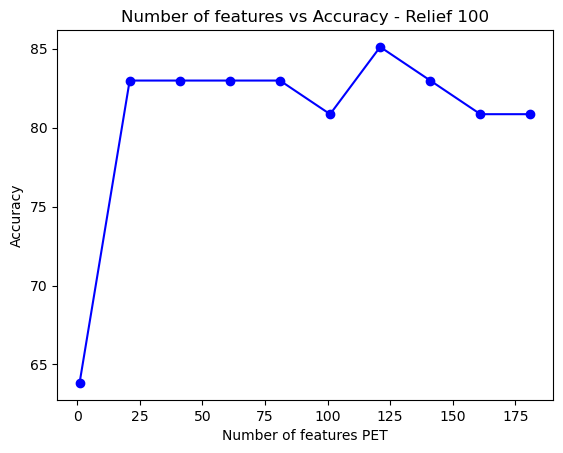

In [65]:
# n_features_to_select is list of begin 0 to 200 with step 20
n_features_to_select = range(1, 200, 20)
modality = 1  # Assuming modality 1 is PET
n_neighbors = 100

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]


accs = []
for n_features in n_features_to_select:
    print(f"Number of features: {n_features}")


    selector = ReliefF(n_features_to_select=n_features, n_neighbors=n_neighbors)

    selector.fit(X_train, y_train)

    X_train_transformed = selector.transform(X_train)   

    clf = KL()
    clf.fit(X_train_transformed, y_train)
    X_test_transformed = selector.transform(X_test)
    y_pred = clf.predict(X_test_transformed)
    cf = confusion_matrix(y_pred, y_test)
    acc = round(np.sum(np.diag(cf)) / np.sum(cf) * 100, 2)
    accs.append(acc)


plt.figure()

plt.plot(n_features_to_select, accs, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of features PET")
plt.ylabel("Accuracy")
plt.title(f"Number of features vs Accuracy - Relief {n_neighbors}")

# Save plot
plt.savefig(f"Relief_n_neighbors={n_neighbors}.png")
plt.show()




### Embedded method

In [34]:
modality = 1  # Assuming modality 1 is PET

X_train = X_list[modality][Z_train, :]
X_test = X_list[modality][Z_test, :]

In [42]:
#using Lasso Regression for Feature Selection
from sklearn.linear_model import Lasso

# Initialize the model
model = Lasso(alpha=0.0001)

# Fit the model
model.fit(X_train, y_train)

# Get the coefficients of the model
coefficients = model.coef_

# Get the indices of the non-zero coefficients
selected_features = np.where(coefficients != 0)[0]

# Select the features based on the non-zero coefficients
X_train_transformed = X_train[:, selected_features]
X_test_transformed = X_test[:, selected_features]

# Fit the model KL with the selected features
clf = KL()
clf.fit(X_train_transformed, y_train)

# Predict using the selected features of the test data
y_pred = clf.predict(X_test_transformed)
cf = confusion_matrix(y_pred, y_test)
acc = round(np.sum(np.diag(cf)) / np.sum(cf) * 100, 2)
print(f"Modality: {modality}", cf, acc)

# Print the selected features
selected_features




Modality: 1 [[20  5]
 [ 4 18]] 80.85


array([  0,   2,   3,   5,   9,  10,  14,  16,  17,  20,  22,  25,  27,
        28,  31,  33,  34,  36,  37,  39,  40,  43,  44,  45,  46,  47,
        48,  49,  50,  52,  54,  56,  57,  58,  60,  61,  62,  64,  66,
        68,  69,  70,  72,  74,  75,  76,  77,  78,  82,  83,  84,  86,
        89,  90,  91,  93,  94,  95,  98,  99, 100, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 113, 114, 116, 117, 118, 120, 121, 123,
       124, 129, 132, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 153, 155, 156, 157, 160, 162, 163,
       164, 166, 171, 172, 174, 177, 178, 179, 180, 181, 184, 185, 186,
       187, 188, 189, 193, 194, 195, 196, 198, 199])

## TKL

ic| "TKL": 'TKL'
    acc: 72.34
    cf: array([[16,  5],
               [ 8, 18]])


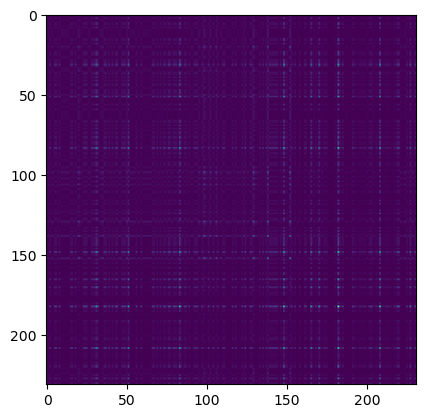

In [6]:
X_train_list = [x[Z_train,:] for x in X_list]
X_test_list = [x[Z_test,:] for x in X_list] 
clf = TKL(iterations=3,n_tree=500, kNN=5)
clf.fit(X_train_list,y_train)

# X_test_array = np.array(X_test_list)
# y_pred = clf.predict(X_test_array)

y_pred = clf.predict(X_test_list)
cf  = confusion_matrix(y_pred, y_test)
acc = round(np.sum(np.diag(cf))/ np.sum(cf)*100,2)
ic("TKL",acc, cf)

plt.figure()
plt.imshow(clf.K)


ic| "Summatuion": 'Summatuion'
    acc: 89.36
    cf: array([[21,  2],
               [ 3, 21]])


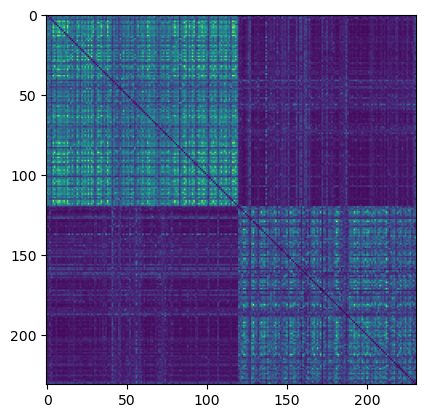

In [ ]:
from kernelSummation import KernelSummation
clf = KernelSummation(n_tree=500)
clf.fit(X_train_list,y_train)
y_pred = clf.predict(X_test_list)
cf  = confusion_matrix(y_pred, y_test)
acc = round(np.sum(np.diag(cf))/ np.sum(cf)*100,2)
ic("Summatuion",acc, cf);
plt.figure()
plt.imshow(clf.K)

